In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip

# load pickle module
import pickle

In [2]:
pop = np.loadtxt('pop_new.csv')

In [4]:
R0 = 2.1
r = 0.09
save_dir = '../../../../../../Volumes/My Passport/branching/branching_results500/'

In [7]:
### normalised the data by the population
### th
th = 10

In [19]:
file_name1 = save_dir + "NewInf_R0-{}_r-{}.npy.gz" .format(np.round(R0,2),np.round(r,2))
f1 = gzip.GzipFile(file_name1, "r")
NewInf =  np.load(f1)
avg_i = np.mean(NewInf,axis=0)
E_daily_per_pop = avg_i/pop[:,None]*100000 ### all the simulation (500, 3142, 60)
position = np.where(E_daily_per_pop[:,59]>th)

In [20]:
E_daily_per_pop[position].shape

(37, 60)

Text(0, 0.5, 'normalised by populations X 100000')

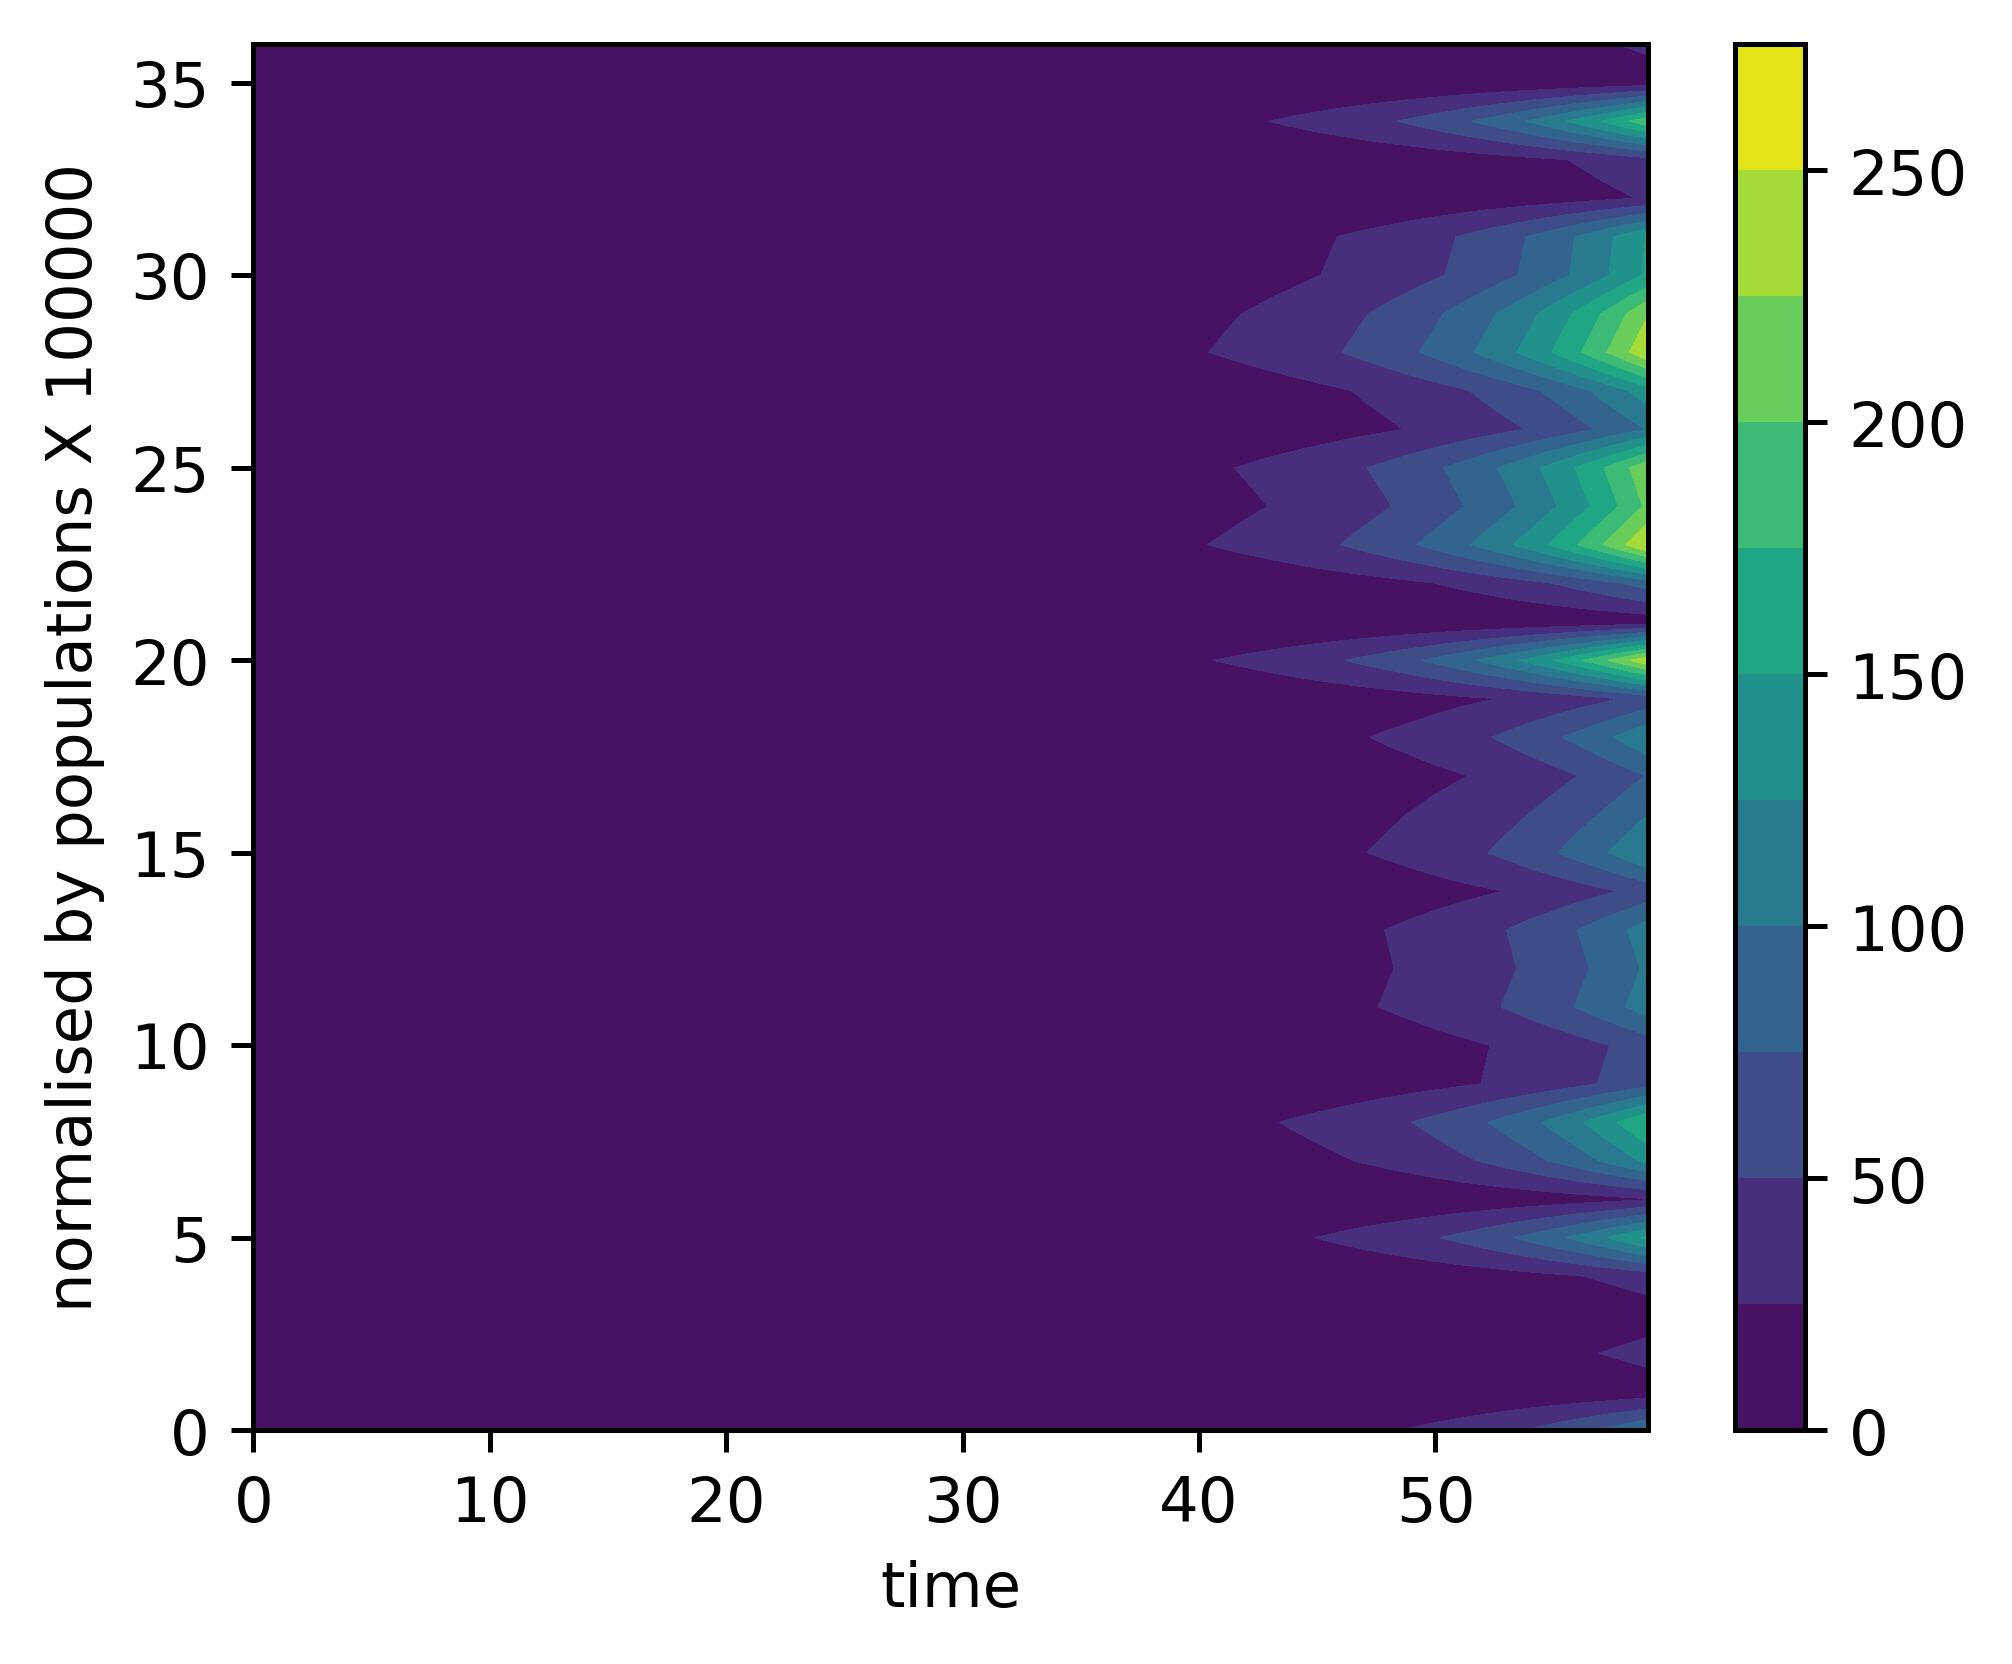

In [21]:
x = np.array(range(60))
y = np.array(range(37))

X, Y = np.meshgrid(x, y)

Z = E_daily_per_pop[position]
# Z = g_i[:,30:]

fig1, ax2 = plt.subplots(figsize=(5, 4), dpi=450)
contour = ax2.contourf(X, Y, Z, 10, cmap=plt.cm.viridis) #vmax=36
# contour = ax2.contourf(X,Y,Z,cmap=cmapmine, vmin=0, vmax=1)

# contour = ax2.imshow(Z,cmap=plt.cm.coolwarm)

# Add colorbar
cbh = plt.colorbar(contour, orientation='vertical', pad=0.05)
plt.xlabel('time')
plt.ylabel('normalised by populations X 100000')

In [17]:
rs = np.arange(0.01, 1, 0.02)
rs_selected = [0,1,2,3,4,5,6,25,49] ### select some r values
rs = rs[rs_selected]

In [49]:
rs

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.51, 0.99])

In [16]:
Inference_mean = np.zeros((9,3142,60))
Inference_std = np.zeros((9,3142,60))
Inference_ensemble_std = np.zeros((9,3142,60))
Observation_i = np.zeros((9,3142,60))

(array([0.00283665, 0.00920465, 0.009552  , 0.00387869, 0.00219985,
        0.00081047, 0.00011578, 0.00023156, 0.        , 0.00011578]),
 array([ 37.10252594,  71.65027795, 106.19802996, 140.74578197,
        175.29353398, 209.84128599, 244.38903801, 278.93679002,
        313.48454203, 348.03229404, 382.58004605]),
 <BarContainer object of 10 artists>)

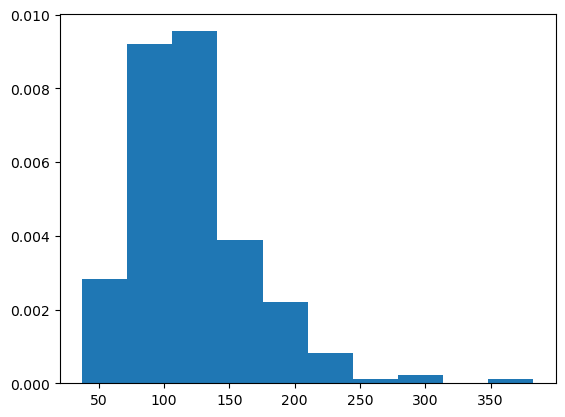

In [50]:
plt.hist(E_daily_per_pop_i[:,308,59],density=True)

In [27]:
save_dir = '../../../../../../Volumes/My Passport/branching/branching_results500/'
for r_idx in range(9):
    print(r_idx)
    r_i = rs[r_idx]
    file_name1 = save_dir + "NewInf_R0-{}_r-{}.npy.gz" .format(np.round(R0,2),np.round(r_i,2))
    f1 = gzip.GzipFile(file_name1, "r")
    NewInf =  np.load(f1)
    E_daily_per_pop_i = NewInf/pop[None,:,None]*100000 
    
    avg_i = np.mean(E_daily_per_pop_i,axis=0)
#     avg_i[avg_i == 0] = 0.000000000000001
#     log_avg_i = np.log(avg_i)
    variance = (avg_i**2)*0.1 + 20
    std_new = np.sqrt(variance)
    std_ens = np.std(E_daily_per_pop_i,axis=0)
#     special = np.log(0.000000000000001)
#     std_new[log_avg_i==special] = 8.881784197001252e-15
    
    Inference_mean[r_idx,:] = avg_i
    Inference_std[r_idx,:] = std_new
    Inference_ensemble_std[r_idx,:] = std_ens
    temp = NewInf[0,:,:]/pop[:,None]*100000 
#     temp[temp==0] = 0.000000000000001
#     obser_ts = np.log(temp) ## take the log
#     obser_ts = temp/pop[:,None]*100000
    Observation_i[r_idx,:,:] = temp

0
1
2
3
4
5
6
7
8


In [28]:
th = 10
R_loglikelihood_sum = np.zeros((9,9)) ### different ranges
R_loglikelihood_maxtrix = dict()
for i in range(9):
    observed_ts = Observation_i[i]
    county_position = np.where(observed_ts[:,59] > th)
    mle_matrix = observed_ts[county_position]
    std_matrix = Inference_ensemble_std[i][county_position]
    for r_idx in range(9):
#         print(r_idx)
        mean_r = Inference_mean[r_idx][county_position]
        std_r = Inference_std[r_idx][county_position]
    #     std_r_ma = mean_county_r*0.1+1
        M_likelihood = SSA.norm.pdf(mle_matrix,loc=mean_r,scale=std_r)
        M_likelihood[M_likelihood==0]=0.0000001
#         M_likelihood = np.clip(M_likelihood, 1e-10, None)
#         for t in range(60):
        R_loglikelihood_maxtrix[(i,r_idx)] = np.log(M_likelihood)
        R_loglikelihood_sum[i,r_idx] = np.sum(np.log(M_likelihood))

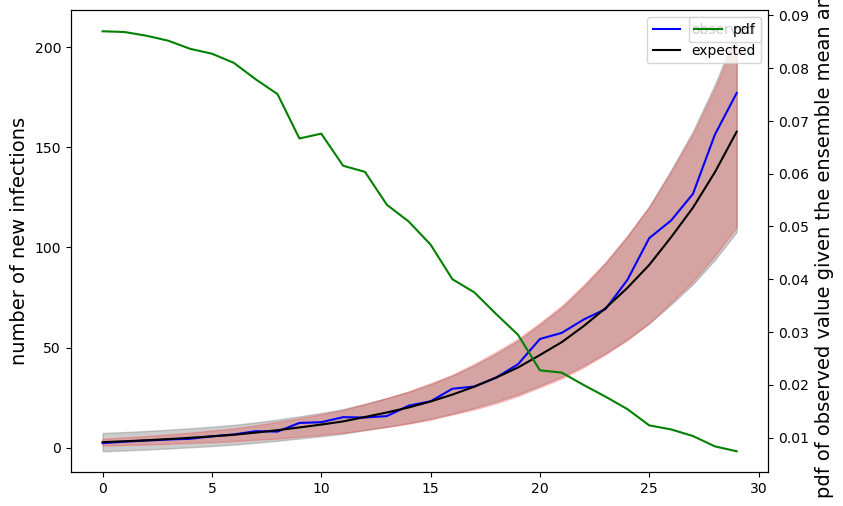

In [32]:
mean_r = Inference_mean[7][county_position]
std_r = Inference_std[7][county_position]
std_matrix = Inference_ensemble_std[7][county_position]

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()  

ax1.plot(mle_matrix[20,30:],label='observed',color = 'blue')
ax1.plot(mean_r[20,30:],label='expected',color='black')
ax1.fill_between(range(30),mean_r[20,30:]+std_r[20,30:],mean_r[20,30:]-std_r[20,30:],alpha=0.4,color='grey')
ax1.fill_between(range(30),mean_r[20,30:]+std_matrix[20,30:],mean_r[20,30:]-std_matrix[20,30:],alpha=0.2,color='red')
ax1.set_ylabel('number of new infections',size=14)
ax1.legend()

ax2.plot(SSA.norm.pdf(mle_matrix[20,30:],loc=mean_r[20,30:],scale=std_r[20,30:]),label='pdf',color='green')
ax2.set_ylabel('the pdf of observed value given the ensemble mean and std',size=14)
ax2.legend()

In [41]:
th = 5
R_loglikelihood_sum = np.zeros((9,9)) ### different ranges
R_loglikelihood_maxtrix = dict()
for i in range(9):
    observed_ts = Observation_i[i]
    county_position = np.where(observed_ts[:,59] > th)
    mle_matrix = observed_ts[county_position]
    std_matrix = Inference_ensemble_std[i][county_position]
    for r_idx in range(9):
#         print(r_idx)
        mean_r = Inference_mean[r_idx][county_position]
        std_r = Inference_std[r_idx][county_position]
    #     std_r_ma = mean_county_r*0.1+1
        M_likelihood = SSA.norm.pdf(mle_matrix[:,40:],loc=mean_r[:,40:],scale=std_r[:,40:])
        M_likelihood[M_likelihood==0]=1e-10
#         M_likelihood = np.clip(M_likelihood, 1e-10, None)
#         for t in range(60):
        R_loglikelihood_maxtrix[(i,r_idx)] = np.log(M_likelihood)
        R_loglikelihood_sum[i,r_idx] = np.sum(np.log(M_likelihood))

In [39]:
R_loglikelihood_maxtrix[(1,1)]

array([[-2.45822732, -2.46490406, -2.47052102, -2.49463599, -2.48924159,
        -2.54576265, -2.54295501, -2.5293548 , -2.5913654 , -2.55735229],
       [-2.80053378, -2.87489948, -2.8402272 , -3.04460554, -3.00685886,
        -2.96594541, -2.91708745, -2.86959415, -3.0653077 , -2.75921363]])

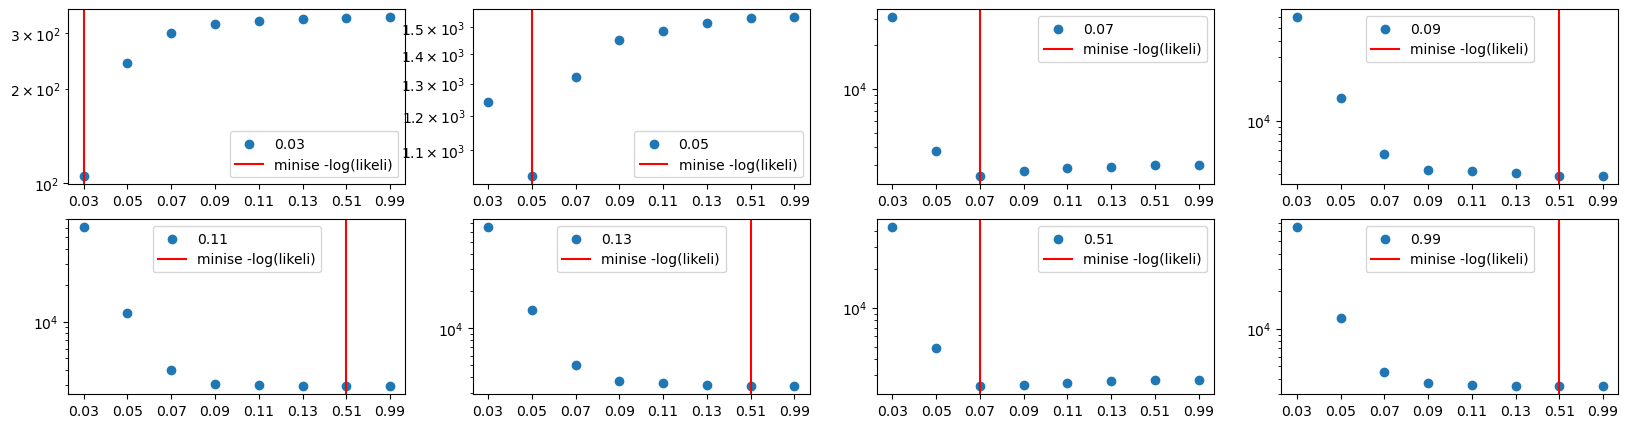

In [42]:
fig, axs = plt.subplots(2,4,figsize=(20,5))
for i in range(1,9):
    row = int((i-0.1)/4)
    col = int((i-0.1)%4)
    ax = axs[row,col]
    pos_le = -R_loglikelihood_sum[i,1:]
    mle = np.where( pos_le == np.min(pos_le))[0][0]
#     print(mle)
    ax.scatter(range(1,9), -R_loglikelihood_sum[i,1:],label = np.round(rs[i],2))
    ax.axvline(mle+1, color='red',label='minise -log(likeli)')
    ax.set_yscale('log')
    ax.set_xticks(range(1,9))
    ax.set_xticklabels(np.round(rs[1:],2))
    
    ax.legend()
plt.show()
# plt.close()

In [46]:
th = 10
R_loglikelihood_sum = np.zeros((9,9)) ### different ranges
R_loglikelihood_maxtrix = dict()
for i in range(9):
    observed_ts = Observation_i[i]
    county_position = np.where(observed_ts > th)
    mle_matrix = observed_ts[county_position]
    std_matrix = Inference_ensemble_std[i][county_position]
    for r_idx in range(9):
#         print(r_idx)
        mean_r = Inference_mean[r_idx][county_position]
        std_r = Inference_std[r_idx][county_position]
    #     std_r_ma = mean_county_r*0.1+1
        M_likelihood = SSA.norm.pdf(mle_matrix,loc=mean_r,scale=std_r)
        M_likelihood[M_likelihood==0]=1e-10
#         M_likelihood = np.clip(M_likelihood, 1e-10, None)
#         for t in range(60):
        R_loglikelihood_maxtrix[(i,r_idx)] = np.log(M_likelihood)
        R_loglikelihood_sum[i,r_idx] = np.sum(np.log(M_likelihood))

In [48]:
R_loglikelihood_maxtrix[(1,1)] 

array([], dtype=float64)

/var/folders/vx/g_l159t12yb63094n730n4pm0000gn/T/ipykernel_32730/2932113782.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


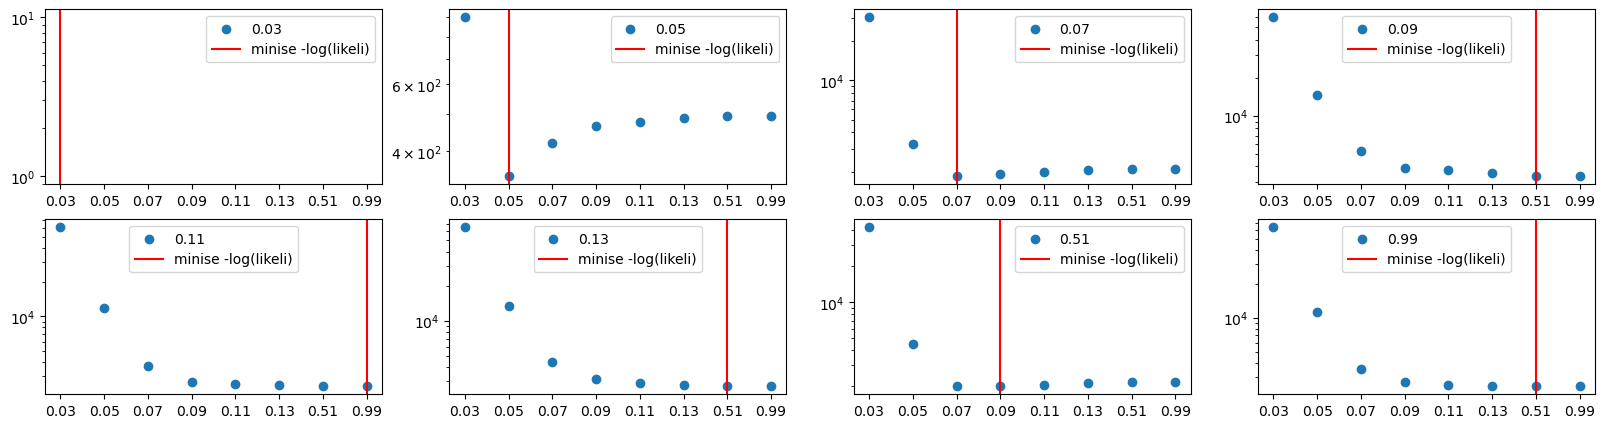

In [47]:
fig, axs = plt.subplots(2,4,figsize=(20,5))
for i in range(1,9):
    row = int((i-0.1)/4)
    col = int((i-0.1)%4)
    ax = axs[row,col]
    pos_le = -R_loglikelihood_sum[i,1:]
    mle = np.where( pos_le == np.min(pos_le))[0][0]
#     print(mle)
    ax.scatter(range(1,9), -R_loglikelihood_sum[i,1:],label = np.round(rs[i],2))
    ax.axvline(mle+1, color='red',label='minise -log(likeli)')
    ax.set_yscale('log')
    ax.set_xticks(range(1,9))
    ax.set_xticklabels(np.round(rs[1:],2))
    
    ax.legend()
plt.show()
# plt.close()